In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('MBB.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,6/1/2018,11783.9,11642.9,11965.2,11562.3,15.87M,0.52%
1,6/4/2018,12267.4,11723.5,12267.4,11683.2,16.32M,4.10%
2,6/5/2018,12267.4,12247.2,12408.4,12005.5,13.13M,0.00%
3,6/6/2018,12307.6,12126.4,12388.2,12045.8,17.76M,0.33%
4,6/7/2018,12448.7,12408.4,12650.1,12327.8,22.65M,1.15%


In [3]:
# Take AR Model of lag = 3, 2 differencing for stationary
train_size = int(0.5 * len(df))
test_size = len(df) - train_size

train_data = df['Price'].iloc[:train_size]
test_data =  df['Price'].iloc[train_size:]

In [4]:
from pmdarima.arima import auto_arima
best_arima = auto_arima(train_data,trace=True)
best_arima.fit(train_data)
print(best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8233.109, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8245.783, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8247.797, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8247.785, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8243.786, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8244.939, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8245.753, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8235.100, Time=1.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=8235.056, Time=1.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8247.847, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8246.318, Time=1.76 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8247.606, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8236.156, Time=1.78 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8231.107, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [5]:
# summary of fit model
arimax_train = df[['Price','High']].iloc[:train_size]
arimax_test = df[['Price','High']].iloc[train_size:]
arimax_model = ARIMA(arimax_train['Price'],exog=arimax_train['High'],order=(2,1,2))
arimax_fitted = arimax_model.fit()
print(arimax_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  621
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3763.547
Date:                Fri, 16 Jun 2023   AIC                           7539.094
Time:                        22:14:25   BIC                           7565.673
Sample:                             0   HQIC                          7549.425
                                - 621                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.9944      0.009    106.720      0.000       0.976       1.013
ar.L1          0.1667      0.178      0.937      0.349      -0.182       0.516
ar.L2          0.1993      0.036      5.590      0.0

C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_arimax= arimax_fitted.predict(start=len(df)-test_size,end=len(df)-1,exog= arimax_test['High'])

# 5. Quá trình Validate
x_val= np.array(df['Price'].index).reshape(-1, 1)
y_val = np.array(df['Price'])
y_pred_val_arimax =  arimax_fitted.predict(start=0,end=train_size-1,exog=arimax_train['High'])
y_pred_val_arimax = pd.concat([y_pred_val_arimax,y_pred_arimax])

ARIMAX Validation RMSE: 245.71850782242808
ARIMAX Testing RMSE: 331.29551742728415
Validation MAPE: 0.9057212874300492
Testing MAPE: 1.0489291111360424
Validation MAE: 146.6479321566111
Testing MAE: 214.72148798036818


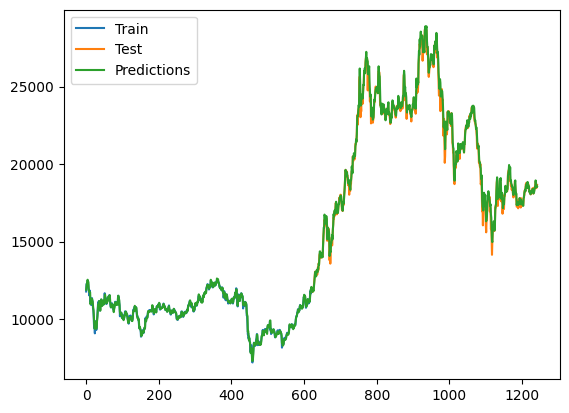

In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val_arimax - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_arimax - y_test)**2))
print('ARIMAX Validation RMSE:', valid_rmse)
print('ARIMAX Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val_arimax - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred_arimax - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val_arimax - y_val))
test_mae = np.mean(np.abs(y_pred_arimax - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(df['Price'].index, y_pred_val_arimax)
# plt.plot(last_data,y_next_10_arima)
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()